# Monet using GAN

Below the prerequisite modules, data and HW are set up. 

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/photo_tfrec/photo12-352.tfrec
/kaggle/input/gan-getting-started/photo_jpg/fb97febc5f.jpg
/kaggle/input/gan-getting-started/monet_tfrec/monet12-60.tfrec


In [2]:
import os
import matplotlib.pyplot as plt
import time 
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa
# from kaggle_datasets import KaggleDatasets

if os.path.exists(r'C:\Users\kuusnin\tempwork\temp\gan-getting-started'):
    datapath = r'C:\Users\kuusnin\tempwork\temp\gan-getting-started'
elif os.path.exists(r'C:\Users\nikok\Documents\Monet using GAN'):
    datapath = r'C:\Users\nikok\Documents\Monet using GAN'
else:
    datapath = r'/kaggle/input/gan-getting-started'
print(datapath)

/kaggle/input/gan-getting-started


In [3]:
tf.__version__
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver('local')
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
    print("can't initialize tpu, using default, exception: " + str(e))
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: 
can't initialize tpu, using default, exception: TPUs not found in the cluster. Failed in initialization: No OpKernel was registered to support Op 'ConfigureDistributedTPU' used by {{node ConfigureDistributedTPU}} with these attrs: [tpu_embedding_config="", tpu_cancellation_closes_chips=2, is_global_init=false, enable_whole_mesh_compilations=false, compilation_failure_closes_chips=false, embedding_config=""]
Registered devices: [CPU]
Registered kernels:
  <no registered kernels>

	 [[ConfigureDistributedTPU]] [Op:__inference__tpu_init_fn_4]
Number of replicas: 1


In [4]:
print("Available GPUs:", tf.config.list_physical_devices('GPU'))
strategy = tf.distribute.MirroredStrategy()

Available GPUs: []


## Brief description of the problem and data (5 pts)

*Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.*

The objective is to generate 7000+ Monet style paintings either by random seed or using the ~7000 photos provided. There are 300 Monet paintings to train the model with. 

The data is available in two formats: two sets of regular jpg image files and two sets of tfrec-files. *"The TFRecord format is a simple format for storing a sequence of binary records. Converting your data into TFRecord has many advantages, such as: More efficient storage: the TFRecord data can take up less space than the original data; it can also be partitioned into multiple files."* (https://keras.io/examples/keras_recipes/creating_tfrecords/)

Since the TFRecord format is more efficient this work is used as an exercise in usage of TFRecord. Below, the TFRecord filenames are saved and counted. 

In [5]:
monet_files = os.listdir(os.path.join(datapath, 'monet_tfrec'))
photo_files = os.listdir(os.path.join(datapath, 'photo_tfrec'))
monet_filenames = [os.path.join(datapath, 'monet_tfrec', f) for f in monet_files]
photo_filenames = [os.path.join(datapath, 'photo_tfrec', f) for f in photo_files]
print(20*'*', 'Monet paintings', 20*'*')
print('First filename:', monet_files[0], '\nNumber of files:', len(monet_files))
print(20*'*', 'Photos', 20*'*')
print('First filename:', photo_files[0], '\nNumber of files:', len(photo_files))

******************** Monet paintings ********************
First filename: monet12-60.tfrec 
Number of files: 5
******************** Photos ********************
First filename: photo12-352.tfrec 
Number of files: 20


### Figure out the contents of the tfrec files

We do not always know the content of the TFRecord files so a exploratory code below inspects the files.

From the code below we can see that each record/example contains three fields: 
* target: label of the image. Not needed in this work 
* image_name: name of the image
* image: the actual image data

Both of the data sets appear to have the same structure. 

In [6]:
# The following code is adapted from an answer from Microsoft Copilot
import tensorflow as tf
from google.protobuf.json_format import MessageToJson
import json

def iterate_record(dataset):
    # Initialize a counter
    record_count = 0
    # Iterate through the dataset and count the records
    for _ in dataset:
        record_count += 1
    print(f'Total number of records: {record_count}')
    
    # Iterate through the dataset and parse each record
    for raw_record in dataset.take(1):  # Adjust the number to read more records
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        json_message = MessageToJson(example)
        parsed_record = json.loads(json_message)
        print(json.dumps(parsed_record, indent=2)[0:500])

# Create a TFRecordDataset
print(20*'*', 'Monet paintings', 20*'*')
raw_monet_dataset = tf.data.TFRecordDataset(monet_filenames)
iterate_record(raw_monet_dataset)

print('\n' + 20*'*', 'Photos', 20*'*')
raw_photo_dataset = tf.data.TFRecordDataset(photo_filenames)
iterate_record(raw_photo_dataset)


******************** Monet paintings ********************
Total number of records: 300
{
  "features": {
    "feature": {
      "image": {
        "bytesList": {
          "value": [
            "/9j/4AAQSkZJRgABAQEBLAEsAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAEAAQADAREAAhEBAxEB/8QAHQAAAgMBAQEBAQAAAAAAAAAABgcEBQgDAAkBAv/EAEMQAAEDAwIEBAMECQMEAgEFAAMEBQYABxMUIwgVM0MBJFNjFnODNJOjswkRFyVEw9Pj8AIm8xg1VGQhRRIoMUF0gf/EABsBAAIDAQEBAAAAAAA

******************** Photos ********************
Total number of records: 7038
{
  "features": {
    "feature": {
      "image_name": {
        "bytesList": {
          "value": [
            "ZWY4MzNlNjBiNA=="
          ]
        }
      },
      "target": {
        "bytesList": {
          "value": [
            "cGhvdG8="
          ]
        }
      },
      "image": {
        "bytesList": {
          "va

We can parse the data now since the structure of the tfrecord is known. Also batch size of 32 is chosen. 

In [7]:
def normalize(image):
    return (tf.cast(image, tf.float32) / 127.5) - 1

def parse_tfrecord_fn(example):
    feature_description = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["image"] = normalize(example["image"])
    return example

def decode_image(tf_image):
    return ((tf_image['image'].numpy() + 1) * 127.5).astype(int)

BATCH_SIZE = 32
monet_dataset = raw_monet_dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
photo_dataset = raw_photo_dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

In [8]:
# Pick one example from each dataset
sample_monet = next(iter(monet_dataset))
sample_photo = next(iter(photo_dataset))

In [9]:
def get_dims(dataset, name):
    dims = []
    for data in dataset:
        dims.append(data['image'].numpy().shape)
    dims = np.array(dims)
    print(f'Number of images in {name} dataset:', np.sum(dims[:,0]))
    print(f'Unique shapes of the {name} data:', np.unique(dims[:,1:], axis=0))

get_dims(monet_dataset, 'Monet')
get_dims(photo_dataset, 'photos')

Number of images in Monet dataset: 300
Unique shapes of the Monet data: [[256 256   3]]
Number of images in photos dataset: 7038
Unique shapes of the photos data: [[256 256   3]]


The code above shows the number of paintings/photos and the size of each image. They are all the same size 256x256 with 3 channels. 

In [10]:
image_shape = (256, 256, 3)

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

*Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?*

Below a few example images from both datasets are shown.

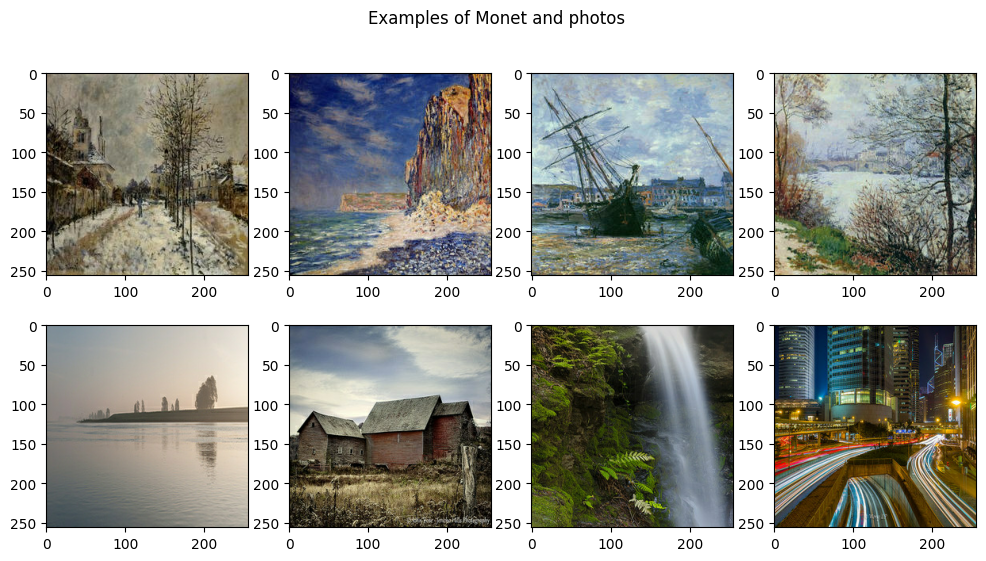

In [11]:
fig = plt.figure(figsize=(12, 6))
i = 0
for i in range(4):
    data = sample_monet['image']
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(np.array((data[i]+1)*127.5).astype(int))
    i += 1
for data in range(4):
    data = sample_photo['image']
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(np.array((data[i]+1)*127.5).astype(int))
    i += 1
fig.suptitle('Examples of Monet and photos')
plt.show()

Next, let's check distribution of real image vs Monet paintings.

In [13]:
def plot_histogram(dataset, title):
    rgb = []
    rgb = [decode_image(d) for d in dataset.take(9)]
    # for data in dataset:
    #     rgb.append(decode_image(data))
    rgb = np.array(rgb)
    # print(rgb.shape)
    pic_channels = ['red', 'green', 'blue']
    rgb_df = pd.DataFrame()
    for i, clr in enumerate(pic_channels):
        df = pd.DataFrame(rgb[:,:,:,:,i].ravel(), columns=['val'])
        df['color'] = clr
        rgb_df = pd.concat([rgb_df, df])
    print('Minimum and maximmum values in ' + title + ' data: ', min(rgb_df.val), '&', max(rgb_df.val))
    sns.histplot(rgb_df.sample(1000), x='val', hue='color', bins=30, multiple='dodge', color=['green', 'blue', 'red'])
    plt.grid()
    plt.title('Histogram of ' + title)
    plt.show()


From the histograms we can see how the intensity distibution of the photos is fairly uniform. Where as Monet paintings are more Gaussian-like distributed. That makes intuitively sense since the Monet painting style is 'blended' and soft compared to the photos. 

Minimum and maximmum values in sample photos data:  0 & 255


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

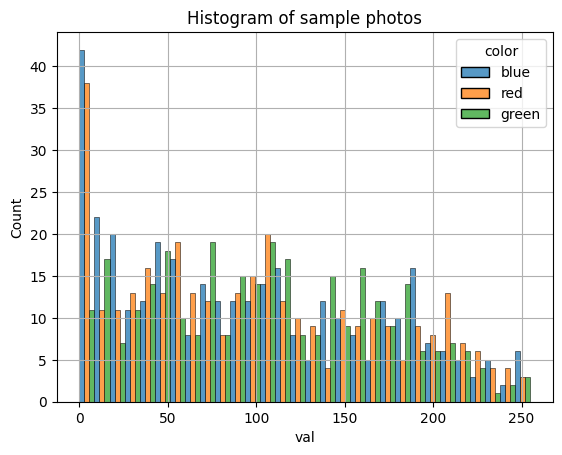

Minimum and maximmum values in Monet paintings data:  0 & 255


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

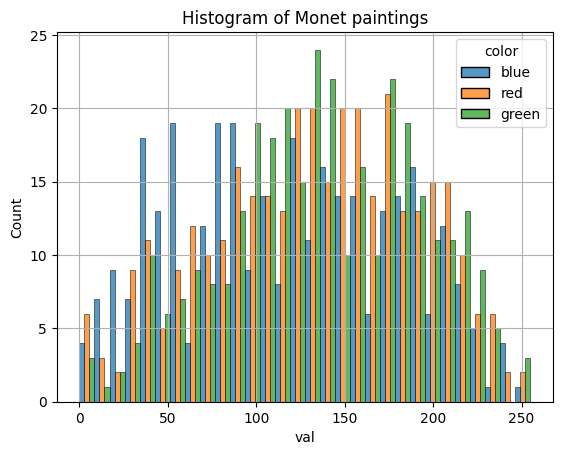

In [14]:
plot_histogram(photo_dataset, title='sample photos')
plot_histogram(monet_dataset, title='Monet paintings')


## Model Architecture (25 pts)

*Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.*

GAN, Generative adversarial network, is suitable for this kind of problem were certain transformation is the objective. The source material for transformation cen either be generated or existing data can be used. 

GAN has two main components, Generator and Discriminator. The discriminator tries to distinguish between fake and real object and the generator tries to create real looking objects. In this work, the generator tries to create Monet style paintings and the discriminator tries to determine if a image is Monet or not. 

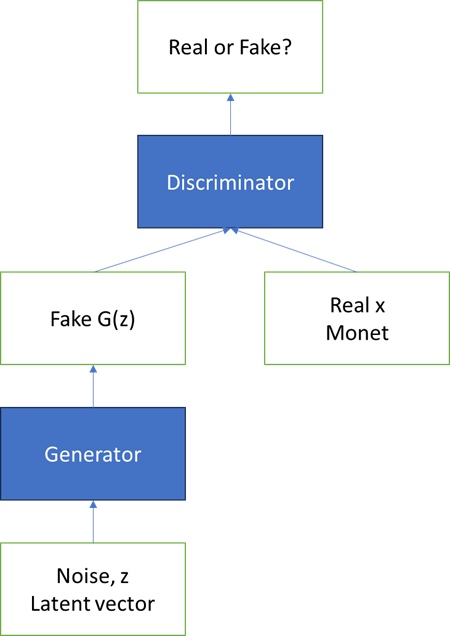

Picture adapted from 

By Zhang, Aston and Lipton, Zachary C. and Li, Mu and Smola, Alexander J. - https://github.com/d2l-ai/d2l-en, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=152265649

### Discriminator
Source: https://keras.io/examples/generative/dcgan_overriding_train_step/
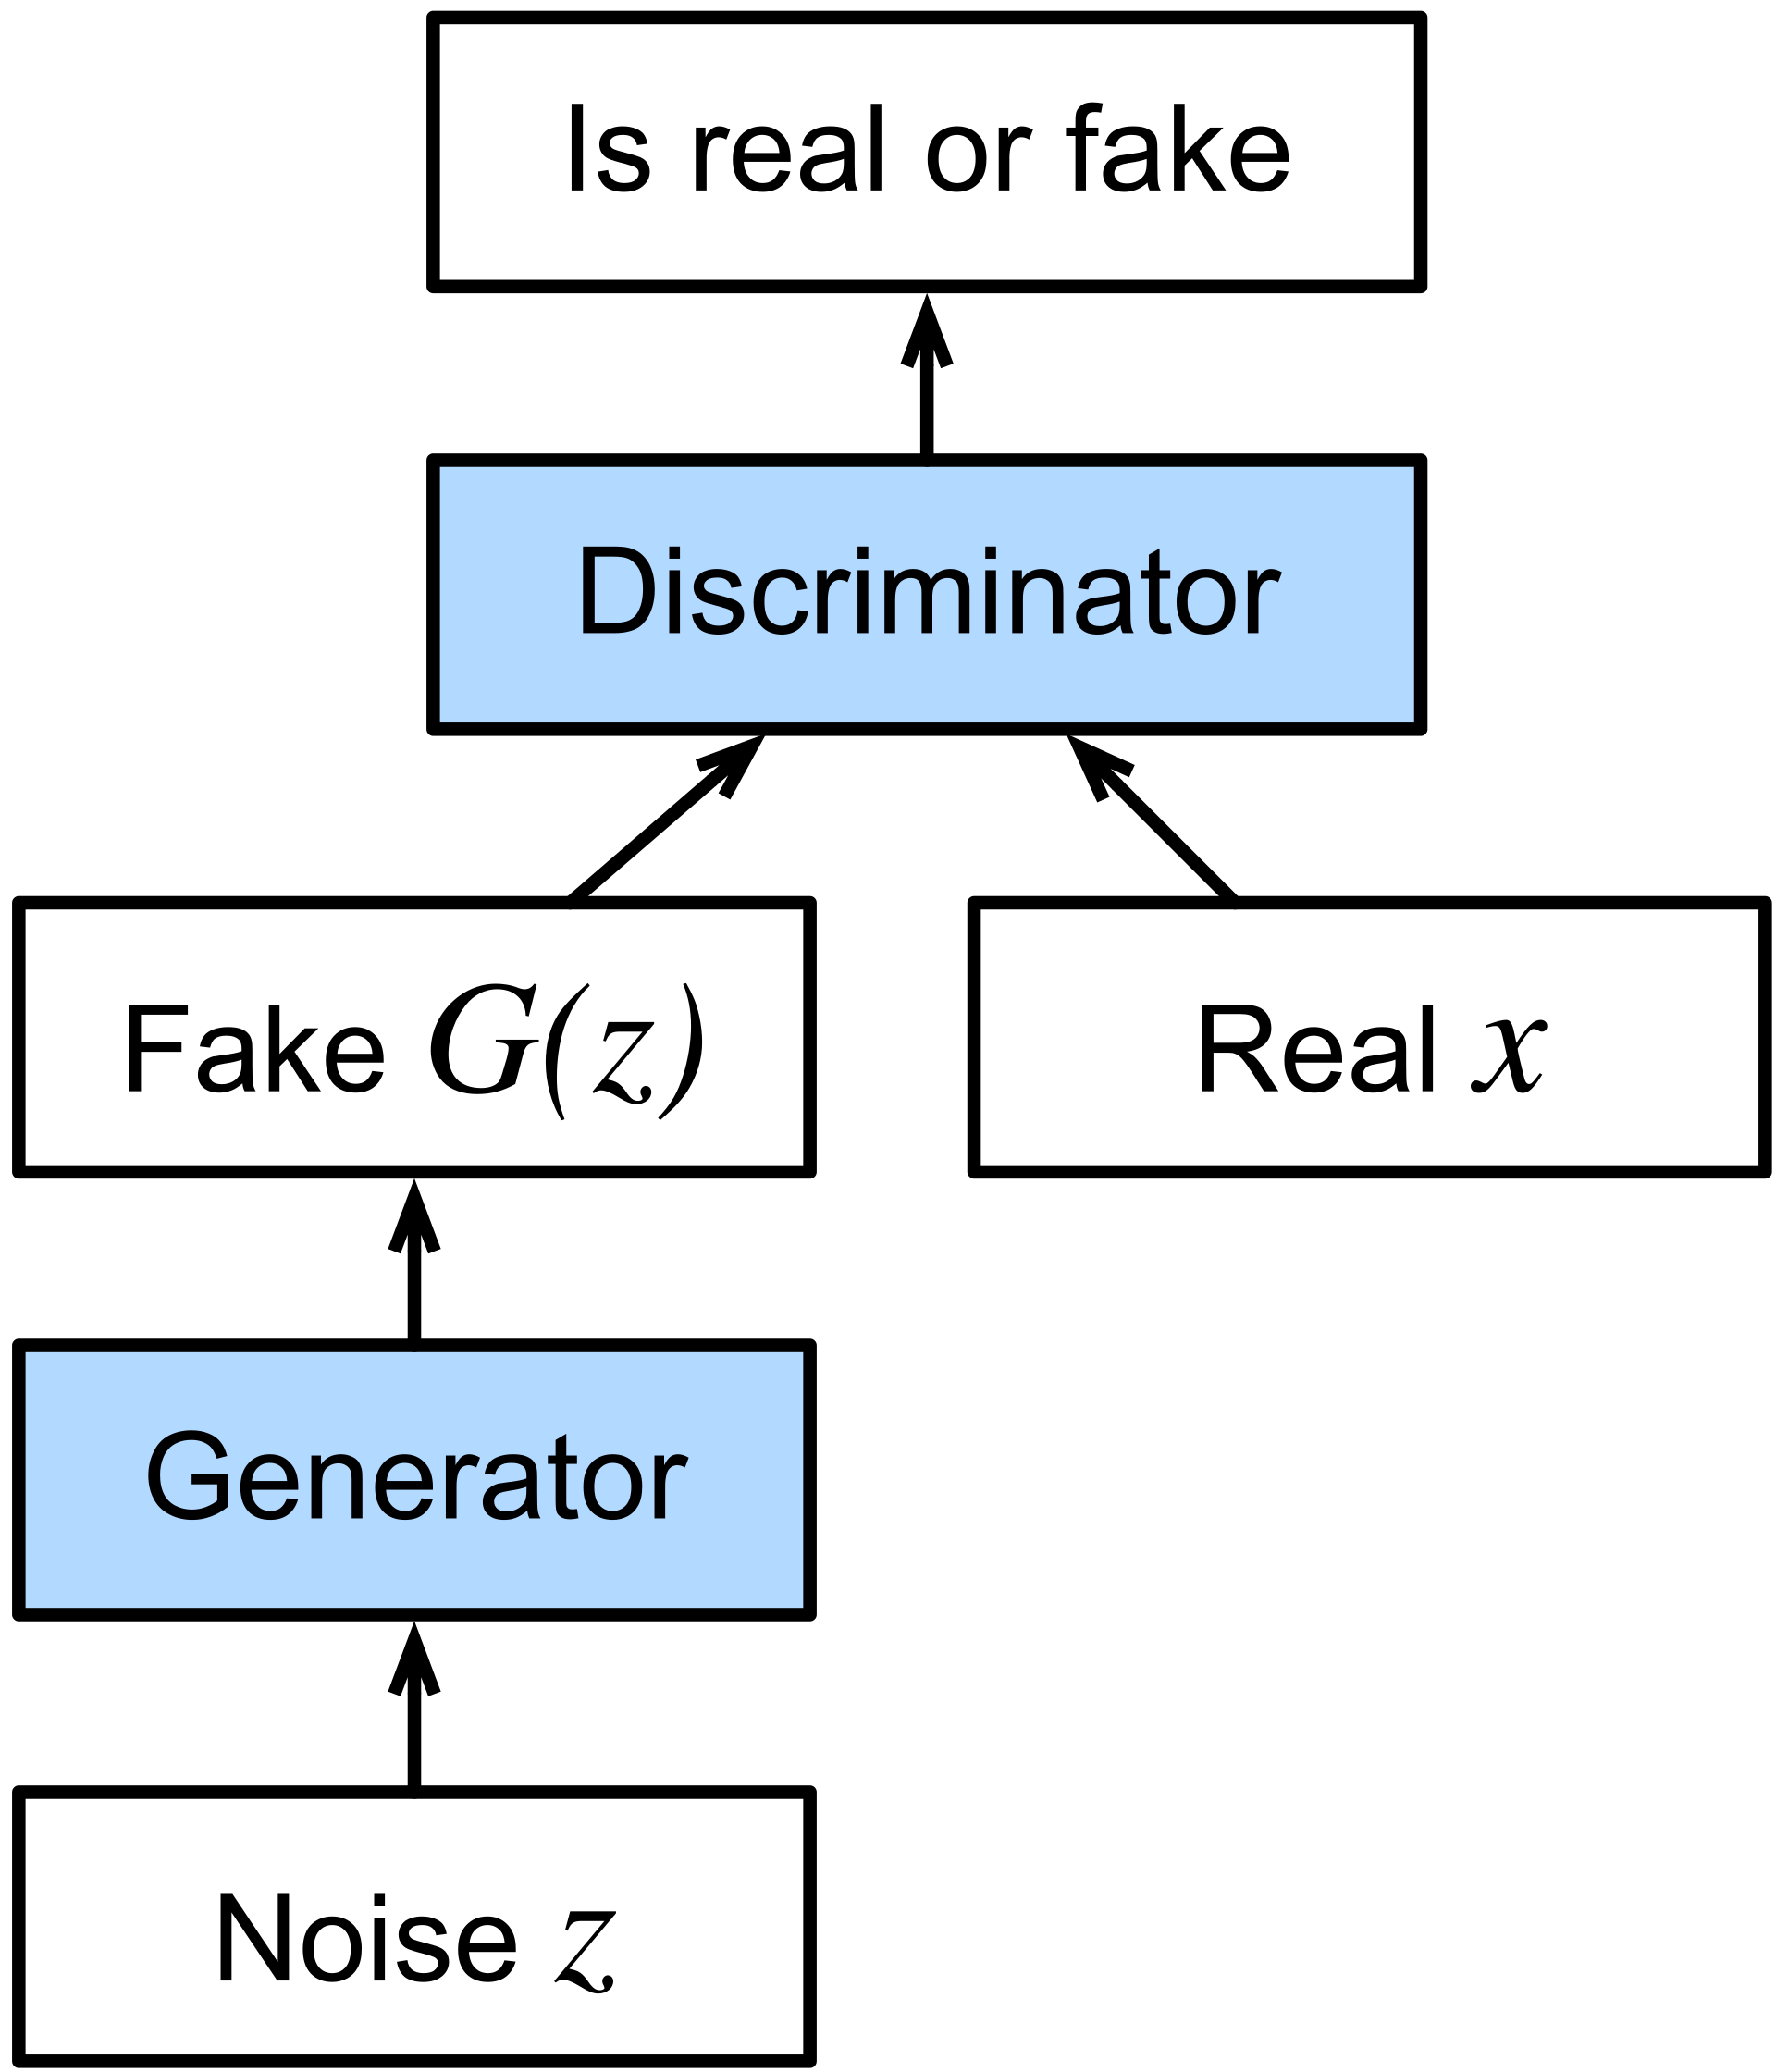
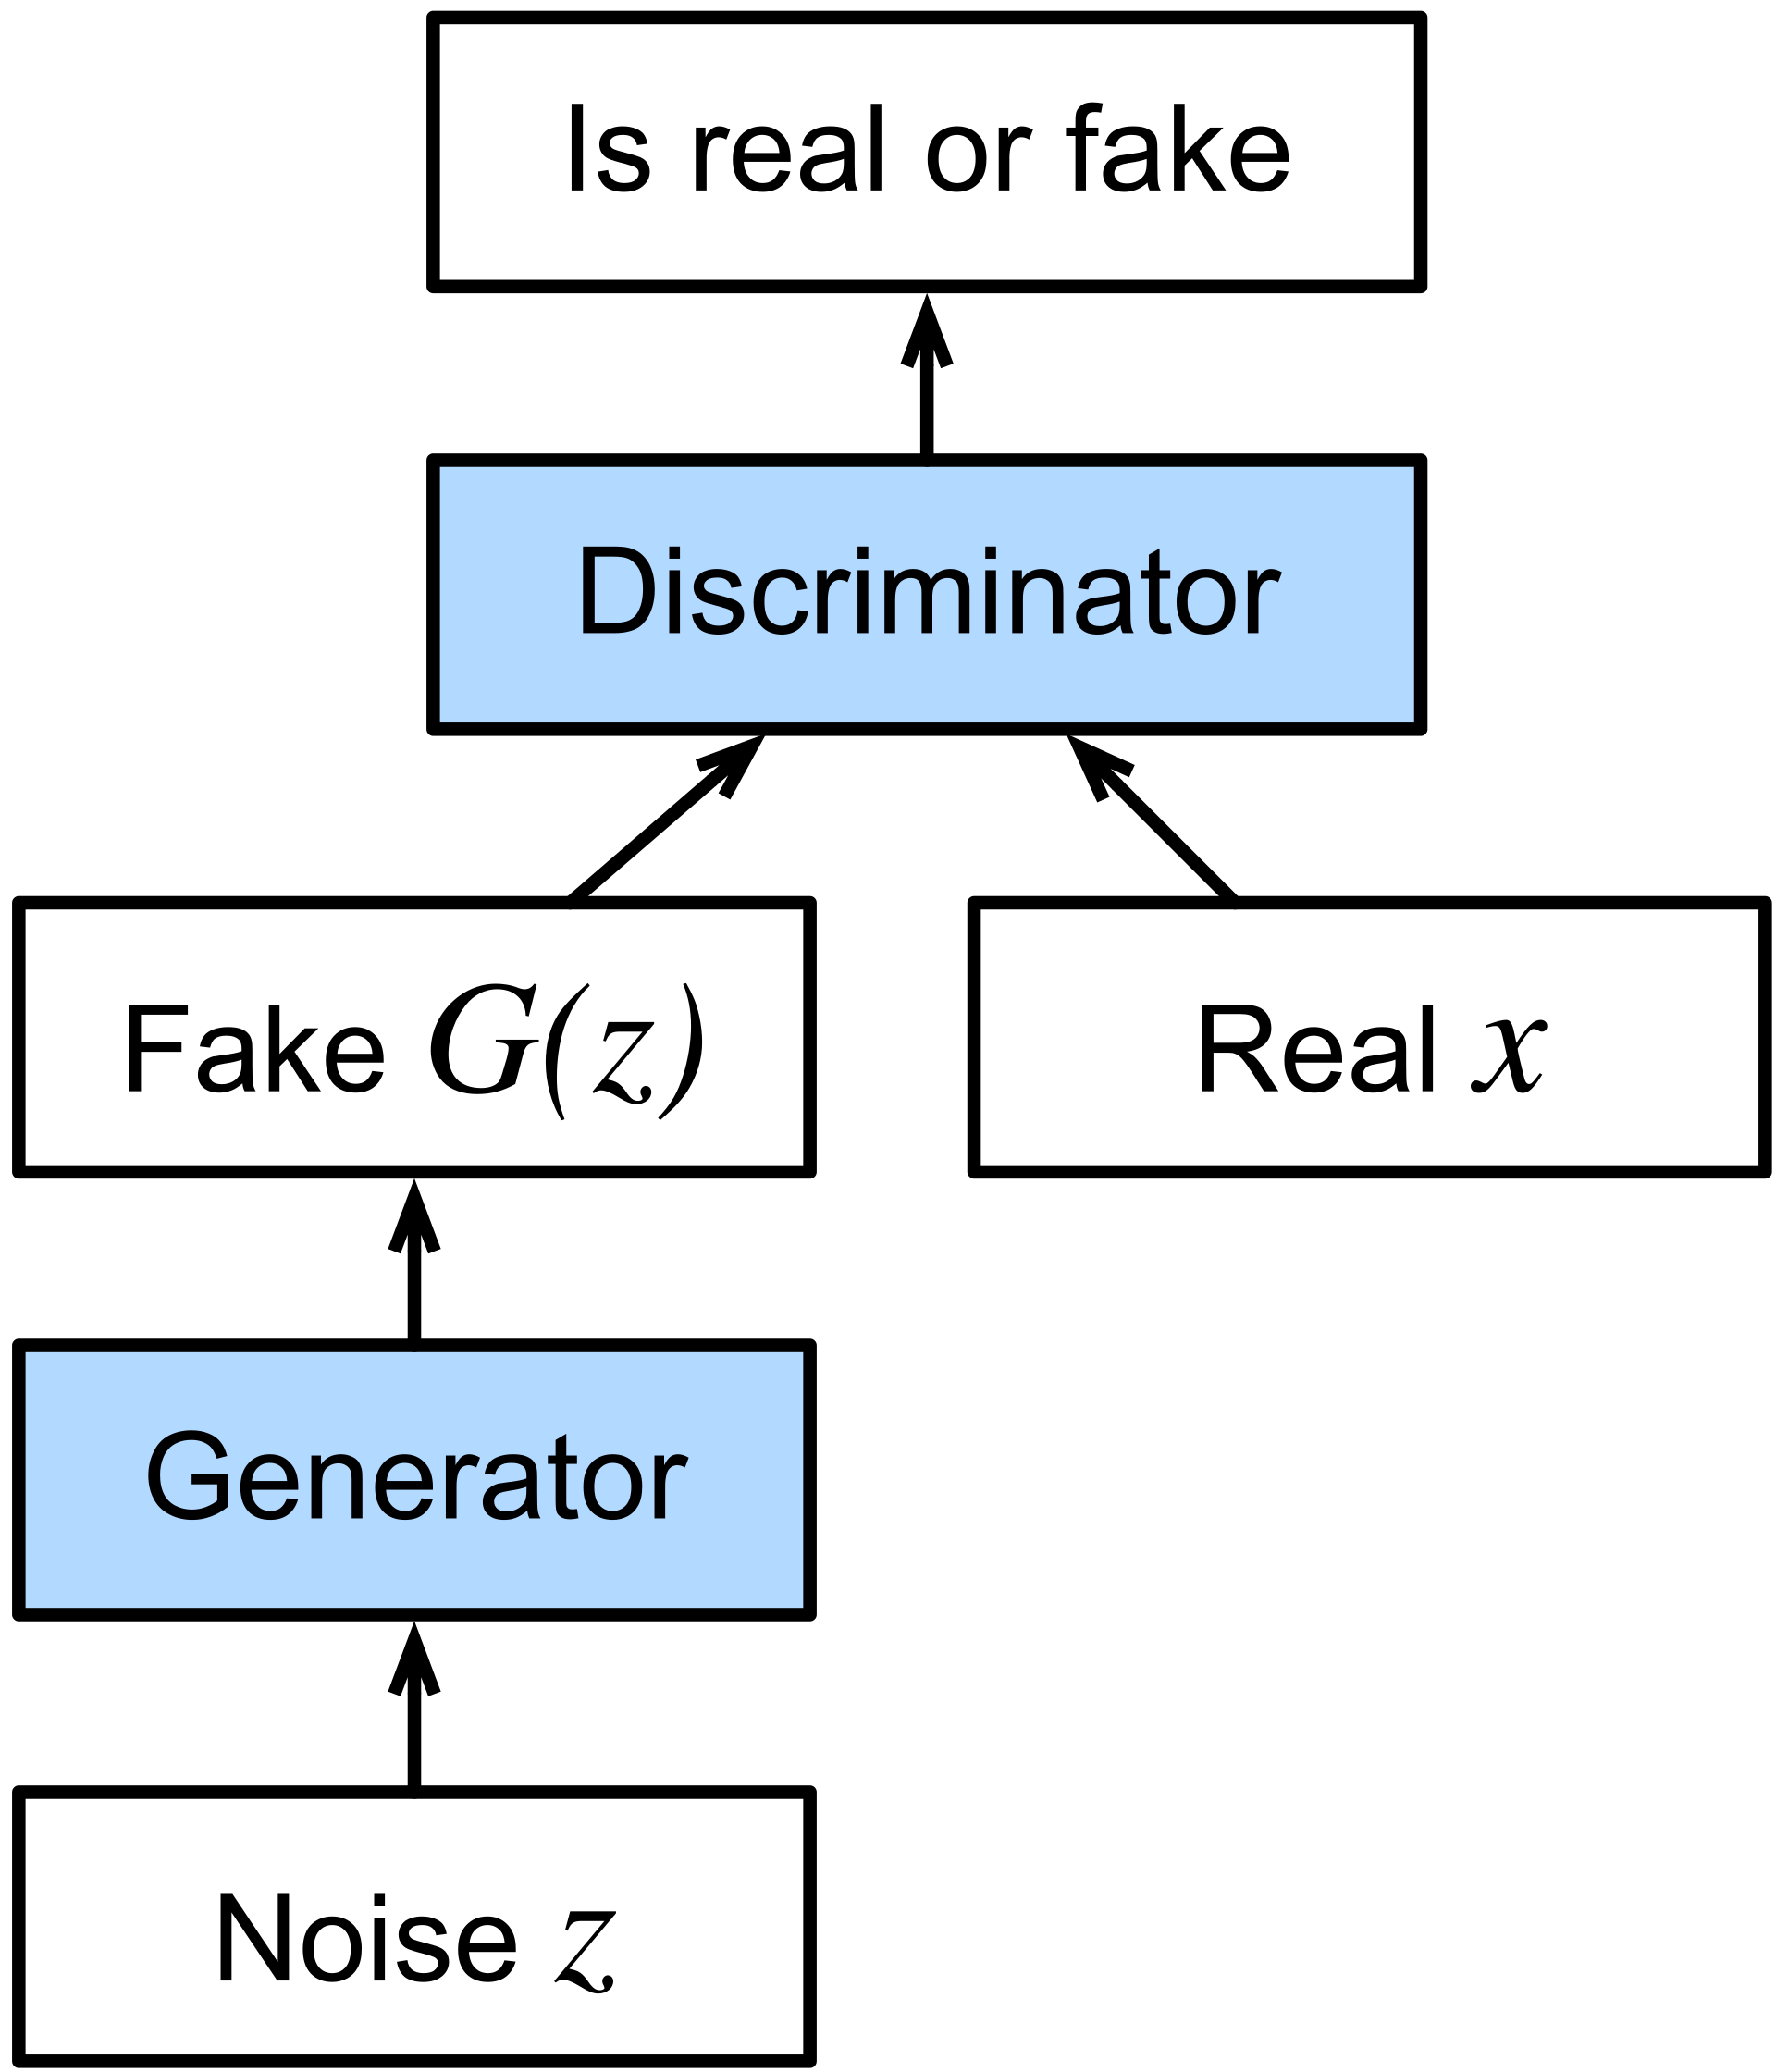
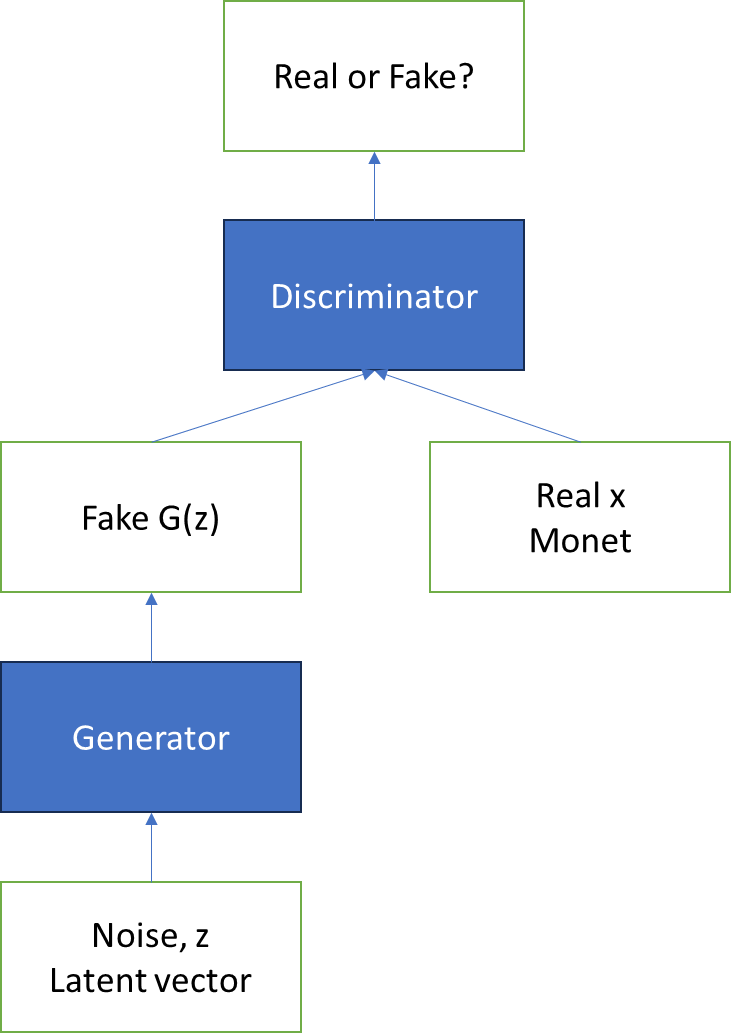
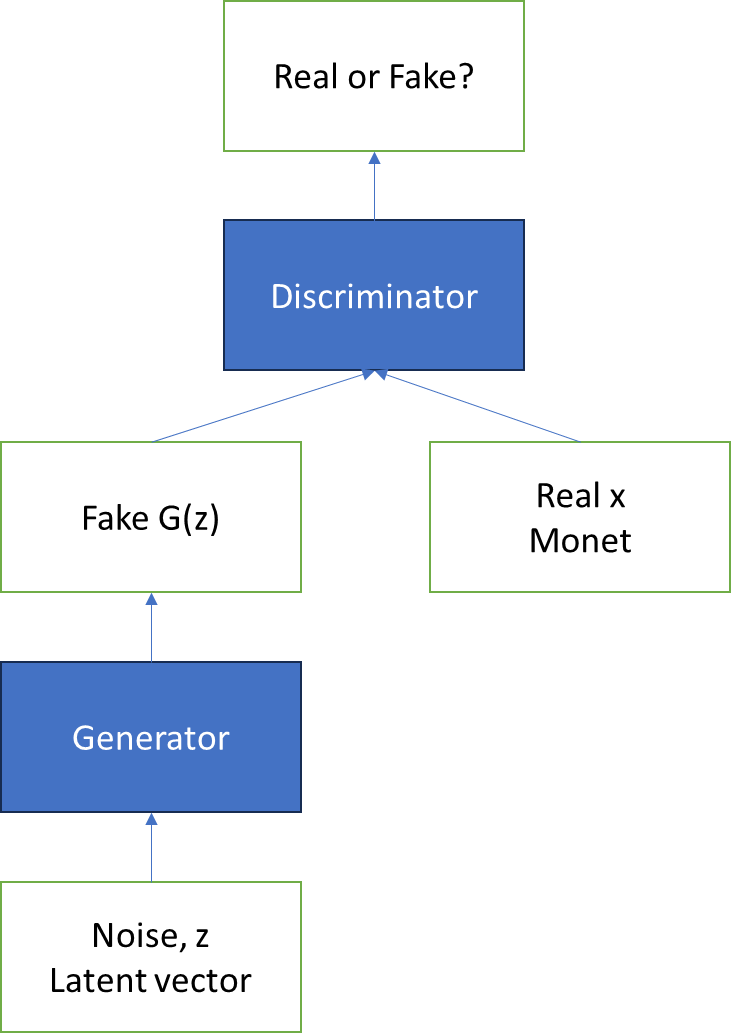
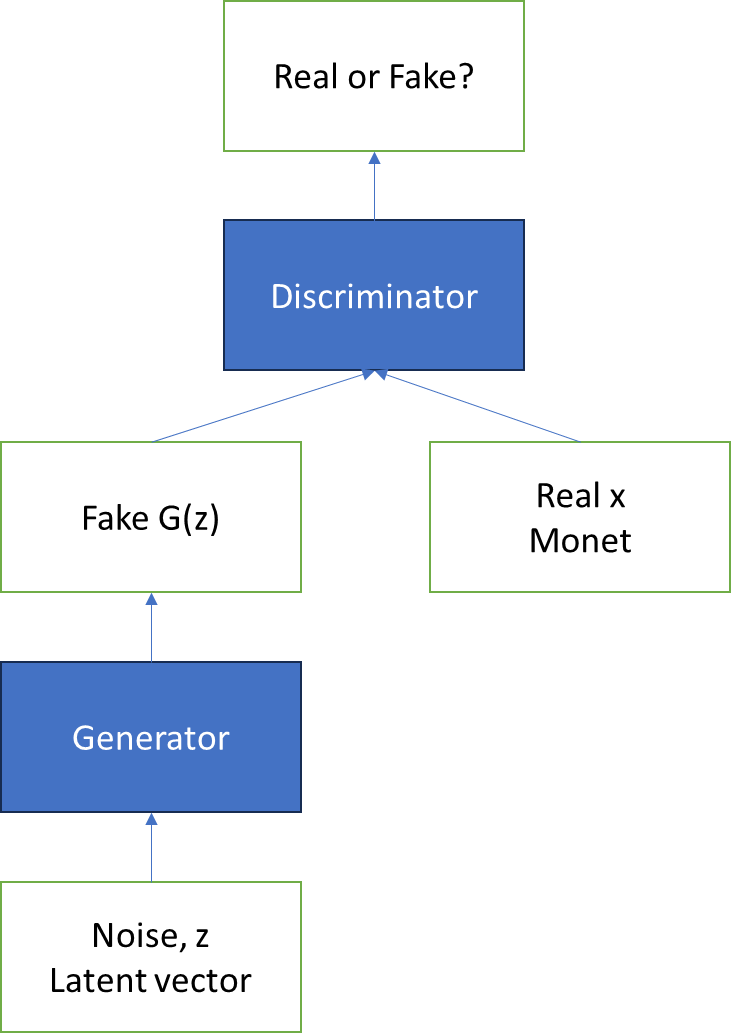
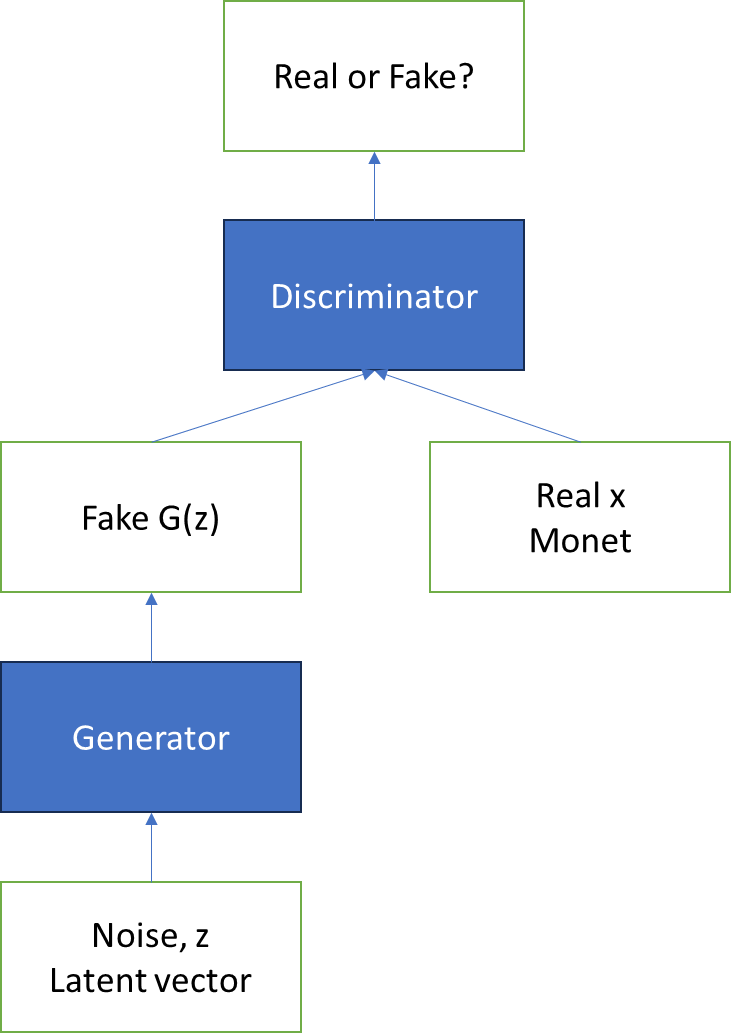
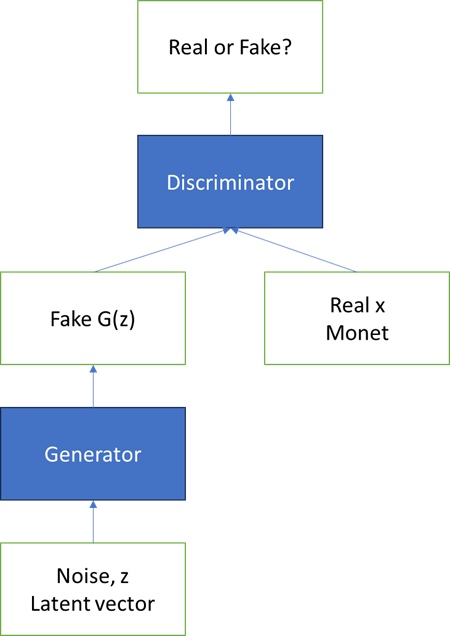

In [ ]:
my_discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(int(64), kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(int(128), kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(int(128), kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
my_discriminator.summary()

In [ ]:
with strategy.scope():
    my_discriminator2 = keras.Sequential(
        [
            keras.Input(shape=(256, 256, 3)),
            layers.Conv2D(int(128), kernel_size=3, strides=2, padding="same"), # was 32
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(int(128), kernel_size=3, strides=2, padding="same"), # was 64
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(int(128), kernel_size=3, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(int(256), kernel_size=3, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(int(512), kernel_size=3, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator",
    )
    my_discriminator2.summary()

#### Generator

Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [ ]:
latent_dim = 100

In [ ]:
my_generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(int(128), kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(int(256), kernel_size=4, strides=4, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(int(512), kernel_size=4, strides=4, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
my_generator.summary()

Second iteration of the generator. More convolution layers and last activation is tanh to give numbers in -1...1 range. 

In [ ]:
with strategy.scope():
    latent_dim = latent_dim
    my_generator2 = keras.Sequential(
        [
            keras.Input(shape=(latent_dim,)),
            layers.Dense(16 * 16 * 512),
            layers.Reshape((16, 16, 512)),
            layers.Conv2DTranspose(int(256), kernel_size=3, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(128), kernel_size=3, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(128), kernel_size=3, strides=2, padding="same"), # was 64
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(128), kernel_size=3, strides=2, padding="same"), # was 32
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
        ],
        name="generator",
    )
    my_generator2.summary()

In [ ]:
with strategy.scope():
    latent_dim = latent_dim
    my_generator3 = keras.Sequential(
        [
            keras.Input(shape=(latent_dim,)),
            layers.Dense(16 * 16 * 512),
            layers.Reshape((16, 16, 512)),
            layers.Conv2DTranspose(int(512), kernel_size=3, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(256), kernel_size=3, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(128), kernel_size=3, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(64), kernel_size=3, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(32), kernel_size=3, strides=1, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
        ],
        name="generator",
    )
    my_generator3.summary()

#### Training

Sources: 

https://www.kaggle.com/code/thuylinh225/generate-monet-images-using-dcgan

https://keras.io/examples/generative/dcgan_overriding_train_step/

In [ ]:
# create loss function for the generator
with strategy.scope():
    def generator_loss(fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    # create loss function for the discriminator
    def discriminator_loss(real_output, fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

#### Callbacks

Source: https://www.kaggle.com/code/thuylinh225/generate-monet-images-using-dcgan

In [ ]:
# Create two separate optimizers for the generator and discriminator
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
# Set the hyperparameters to be used for training
EPOCHS = 1000
BATCH_SIZE = BATCH_SIZE
noise_dim = latent_dim
print('Batch size:', BATCH_SIZE)
print('Latent vector size (same as noise vector size):', noise_dim)

In [ ]:
class DCGAN_model:
    def __init__(self, noise_dim, EPOCHS, BATCH_SIZE, generator, discriminator, dataset):  
        self.noise_dim = noise_dim
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.generator = generator
        self.discriminator = discriminator
        self.dataset = dataset
    
    @tf.function
    def train(self, images):
    
    # Create random noise vector
        noise = tf.random.normal([images.shape[0], noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # generate images use random noise vector
            generated_images = self.generator(noise, training=True)

            # use discriminator to evaluate the real and fake images
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # compute generator loss and discriminator loss
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

            # Compute gradients
            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            # Update optimizers
            generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
        return (gen_loss + disc_loss) * 0.5
    
    @tf.function
    def distributed_train(self, images):
        per_replica_losses = strategy.run(self.train, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
    
    def generate_images(self):
        noise = tf.random.normal([self.BATCH_SIZE, self.noise_dim]) 
        predictions = self.generator.predict(noise)
        return predictions
        
    def generate_and_plot_images(self):      
        image = self.generate_images()
        gen_imgs = 0.5 * image + 0.5
        fig = plt.figure(figsize=(10, 10))
        for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(gen_imgs[i, :, :, :])
            plt.axis('off')
        plt.show()

    def train_loop(self):
        e_ls = []
        mean_ls = []
        for epoch in range(self.EPOCHS):
            start = time.time()

            total_loss = 0.0
            num_batches = 0

            for image_batch in self.dataset:
                loss = self.distributed_train(image_batch['image'])
                total_loss += tf.reduce_mean(loss)
                num_batches += 1
            mean_loss = total_loss / num_batches

            if (epoch+1) % 200 == 0:                                  
                print ('Time for epoch {} is {} sec, mean loss is {}'.format(epoch + 1, time.time()-start, mean_loss))
                self.generate_and_plot_images()
                
                e_ls.append(epoch+1)
                mean_ls.append(mean_loss)
        print("\nMean Loss for every 200 epochs: \n")
        table = pd.DataFrame({"Epoch": e_ls, "Mean Loss": np.array(mean_ls)})
        return table

#### Training

Override the train step.

Source: https://www.kaggle.com/code/thuylinh225/generate-monet-images-using-dcgan

In [ ]:
# train, visualize and print out the result for DCGAN model
gan1 = DCGAN_model(noise_dim, EPOCHS, BATCH_SIZE, my_generator2, my_discriminator2, monet_dataset)
res1 = gan1.train_loop()
res1

## Results and Analysis (35 pts)

*Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.*

*Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.*

The first generator/discriminator did not produce reasonable looking Monet paintings. I suspect that they just did not have enough layers so the 2nd version of generator and discriminator have one additional layer (total of four). Also batch normalization was added. These were used as a new baseline. They produced reasonably good result of 100 with ~45min of GPU time. 

Increasing the number of filters in the CNN layers to minimum number of 128 (some layers up from 32 and 64) improved the score a little, to ~95, but increased the GPU training time to 1h and 45min. 

Leaky RELu with the negative slope of 0.1 was also tried but the results were worse (value of 0.2 is widely used in GAN models). 

| Version | Description | Score
| ----------- | ----------- | ----------- |
| v7  | Baseline | 100.9 |
| v8  | Latent dimension 200 | 124.3 |
| v9  | Leaky RELu with 0.1 slope | 125.0 |
| v10 | Additional hidden CNN layer in the generator | 101.9 |
| v11 | Up to 2000 epochs | 116.7 |
| v12 | Min. 128 filters in CNN |94.5  |



## Submission


In [ ]:
from PIL import Image
import shutil
from keras.saving import load_model
import zipfile
import io

In [ ]:
no_of_pics = 7050
with strategy.scope():
    with zipfile.ZipFile("images.zip", "w") as zipf:    
        p = 1
        for i in range(int(np.ceil(no_of_pics/BATCH_SIZE))):
            print(i, end='\r')
            noise = tf.random.normal([BATCH_SIZE, noise_dim])
            img_batch = my_generator2.predict(noise)
            for img in img_batch:
                image = ((img + 1) * 127.5).astype('uint8')
                # print(image.shape)
                # print(np.min(image.ravel()), np.max(image.ravel()))
                image = Image.fromarray(image)
                # Save the image to an in-memory buffer
                buffer = io.BytesIO()
                image.save(buffer, format="JPEG")
                buffer.seek(0)  # Move to the beginning of the buffer
                # Write the image to the ZIP file
                zipf.writestr(f"image_{p}.jpg", buffer.getvalue())
                p += 1
        plt.imshow(image)

In [ ]:
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
for dirname, _, filenames in os.walk('/kaggle/output'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

file_size_bytes = os.path.getsize('/kaggle/working/images.zip')
print(f"File size (bytes): {file_size_bytes}")
# Convert to other units (optional)
file_size_kb = file_size_bytes / 1024
file_size_mb = file_size_kb / 1024
print(f"File size (KB): {file_size_kb:.2f}")
print(f"File size (MB): {file_size_mb:.2f}")

## Conclusion (15 pts)

*Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?*

Looks like just adding more parameters into the model improved the score the best.

Getting the TPU working with the code was challenging, and in the end I ended up using GPU for training.

Could try to improve the score by changing parameters of the worse than baseline models to opposite direction (i.e., increase leaky RELu slope, decrease latent dimension, etc.) and try to combine all the improvements into one model. Also monitoring the loss while training could help find the optmimal epoch count. 

## Versions
Version 2: Baseline, 100 latent dimension, 1000 epochs.

Version 3: Same, problem with output files.

Version 4: Same, problem with output files. Save directly into zip-file.

Version 5: Same, problem with output files. Don't save the generator (only one file saved). Save as .jpg, not .jpeg.

Version 5: Same, problem with output files. Accidentaly overwrote images.zip.

Version 6: Success, score ~100.

Version 7: Increase latent dimension from 100 to 200.

Version 9: Adjust leaky relu to 0.1.

Version 10: Add another layer into generator ("my_generator3).

Version 11: Increase epochs from 1000 to 2000.

Version 12: Add more filters, minimum of 128 per layer.

# Sources

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

https://keras.io/examples/generative/dcgan_overriding_train_step

https://www.kaggle.com/code/thuylinh225/generate-monet-images-using-dcgan